In [1]:
import glob
import json
import os
import pickle
import unicodedata

from joblib import delayed, Parallel
import numpy as np
import pandas as pd
from PIL import Image
from skimage.feature import hog
from skimage.io import imread
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss
from tqdm.auto import tqdm

In [2]:
pd.options.display.max_rows = pd.options.display.max_columns = 50
pd.options.display.float_format = '{:.3f}'.format

In [3]:
OUTPUT_DIR = os.path.join('..', 'data', 'eda-002')
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
INPUT_DIR = os.path.join(os.path.expanduser('~'), 'datasets', 'nishika', 'bokete')
assert os.path.isdir(INPUT_DIR)
train = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))
sample_submission = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))

In [5]:
cv = pd.read_csv(os.path.join('..', 'fold', 'cv.csv'))
cv

,odai_photo_file_name,oof_fold
0,9fkys1gb2r.jpg,4
1,c6ag0m1lak.jpg,3
2,whtn6gb9ww.jpg,3
3,6yk5cwmrsy.jpg,0
4,0i9gsa2jsm.jpg,4
...,...,...
24957,5ctq9ohpge.jpg,3
24958,dcj9pepjwf.jpg,1
24959,ks04y4iy7i.jpg,2
24960,cgfkktchbz.jpg,4


In [10]:
def make_hog_feature(filepath: str, image_size=(224, 224)):
    image = np.array(Image.open(filepath).resize(image_size))
    if image.ndim == 2:
        image = np.stack((image,) * 3, axis=-1)
    return filepath, hog(image, channel_axis=2).astype('float32')

In [11]:
%%time
filepath_train = os.path.join(OUTPUT_DIR, 'hog_features_train.pkl')
if os.path.isfile(filepath_train):
    X = pd.read_pickle(filepath_train)
else:
    X = Parallel(n_jobs=-1, verbose=4)(
        delayed(make_hog_feature)(os.path.join(INPUT_DIR, 'train', filename))
        for filename in train['odai_photo_file_name']
    )
    X = pd.DataFrame({os.path.basename(filepath): feature for filepath, feature in X}).T
    X.to_pickle(filepath_train)
X = X.loc[train['odai_photo_file_name']]  # same order
X

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 596 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 1280 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 2164 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 3240 tasks      | elapsed:   27.6s
[Parallel(n_jobs=-1)]: Done 4516 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 5984 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 7652 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 9512 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 11572 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 13824 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 16276 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 18920 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 21764 tasks  

CPU times: total: 31.6 s
Wall time: 5min 18s


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,54731,54732,54733,54734,54735,54736,54737,54738,54739,54740,54741,54742,54743,54744,54745,54746,54747,54748,54749,54750,54751,54752,54753,54754,54755
9fkys1gb2r.jpg,0.139,0.242,0.242,0.019,0.118,0.039,0.000,0.014,0.076,0.097,0.061,0.149,0.082,0.035,0.018,0.010,0.041,0.046,0.086,0.073,0.171,0.107,0.045,0.042,0.042,...,0.231,0.231,0.180,0.028,0.000,0.042,0.022,0.097,0.051,0.231,0.205,0.035,0.018,0.003,0.006,0.006,0.044,0.068,0.084,0.084,0.067,0.017,0.000,0.004,0.022
c6ag0m1lak.jpg,0.049,0.006,0.008,0.022,0.065,0.059,0.059,0.014,0.003,0.167,0.000,0.000,0.000,0.000,0.000,0.352,0.352,0.009,0.068,0.000,0.000,0.000,0.015,0.230,0.352,...,0.044,0.000,0.125,0.213,0.024,0.150,0.077,0.122,0.229,0.012,0.010,0.005,0.008,0.010,0.015,0.026,0.081,0.005,0.019,0.031,0.094,0.041,0.068,0.040,0.003
whtn6gb9ww.jpg,0.010,0.001,0.005,0.023,0.017,0.004,0.010,0.019,0.010,0.024,0.003,0.001,0.000,0.002,0.011,0.010,0.037,0.040,0.404,0.058,0.000,0.000,0.000,0.000,0.000,...,0.004,0.004,0.003,0.010,0.023,0.011,0.005,0.059,0.006,0.015,0.034,0.061,0.055,0.020,0.004,0.007,0.259,0.390,0.200,0.024,0.114,0.017,0.019,0.007,0.036
6yk5cwmrsy.jpg,0.446,0.013,0.000,0.000,0.018,0.000,0.000,0.000,0.000,0.446,0.126,0.024,0.007,0.000,0.003,0.000,0.009,0.005,0.046,0.093,0.028,0.004,0.023,0.002,0.001,...,0.017,0.000,0.015,0.028,0.150,0.188,0.301,0.051,0.000,0.000,0.062,0.301,0.301,0.080,0.087,0.096,0.054,0.012,0.033,0.301,0.301,0.099,0.071,0.031,0.038
0i9gsa2jsm.jpg,0.009,0.004,0.000,0.009,0.078,0.157,0.017,0.000,0.000,0.013,0.006,0.022,0.062,0.172,0.013,0.013,0.000,0.000,0.333,0.012,0.002,0.002,0.004,0.002,0.004,...,0.018,0.035,0.155,0.367,0.006,0.004,0.000,0.037,0.001,0.006,0.013,0.123,0.292,0.007,0.004,0.007,0.053,0.001,0.006,0.008,0.041,0.020,0.010,0.004,0.002
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5ctq9ohpge.jpg,0.000,0.000,0.007,0.151,0.219,0.064,0.007,0.011,0.000,0.020,0.000,0.046,0.216,0.148,0.143,0.056,0.000,0.000,0.025,0.000,0.071,0.129,0.219,0.080,0.050,...,0.223,0.081,0.059,0.041,0.014,0.024,0.024,0.223,0.223,0.223,0.111,0.048,0.088,0.014,0.031,0.040,0.171,0.088,0.069,0.177,0.112,0.085,0.062,0.033,0.071
dcj9pepjwf.jpg,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.004,0.000,0.003,0.000,0.006,0.000,0.000,0.000,0.000,0.004,0.000,0.000,0.000,0.004,0.000,0.003,...,0.050,0.049,0.060,0.063,0.041,0.031,0.064,0.049,0.042,0.025,0.054,0.064,0.056,0.039,0.019,0.052,0.037,0.014,0.027,0.020,0.069,0.063,0.050,0.027,0.033
ks04y4iy7i.jpg,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.366,0.000,0.004,0.000,0.003,0.000,0.008,0.000,0.080,0.366,0.000,0.000,0.000,0.000,0.000,0.000,...,0.014,0.068,0.185,0.037,0.048,0.057,0.035,0.015,0.000,0.014,0.076,0.341,0.000,0.007,0.011,0.000,0.005,0.000,0.014,0.015,0.343,0.057,0.021,0.000,0.000
cgfkktchbz.jpg,0.077,0.009,0.010,0.005,0.052,0.105,0.215,0.222,0.043,0.106,0.002,0.030,0.036,0.048,0.122,0.214,0.096,0.069,0.084,0.000,0.000,0.000,0.026,0.178,0.265,...,0.011,0.007,0.015,0.015,0.184,0.203,0.041,0.128,0.009,0.010,0.017,0.007,0.003,0.048,0.141,0.299,0.180,0.008,0.005,0.001,0.004,0.000,0.037,0.084,0.300


In [19]:
mask

0        False
1        False
2        False
3         True
4        False
         ...  
24957    False
24958    False
24959    False
24960    False
24961     True
Name: odai_photo_file_name, Length: 24962, dtype: bool

In [21]:
%%time
prediction_train = []
prediction_valid = []
metrics = {'train_loss': [], 'valid_loss': []}
models = []
assert (X.index == train['odai_photo_file_name']).all()

for oof_fold, fold_df in tqdm(cv.groupby('oof_fold')):

    mask = train['odai_photo_file_name'].isin(fold_df['odai_photo_file_name'])
    X_train = X[X.index.isin(fold_df['odai_photo_file_name'])]
    X_valid = X[~X.index.isin(fold_df['odai_photo_file_name'])]
    y_train = train.loc[mask, 'is_laugh']
    y_valid = train.loc[~mask, 'is_laugh']

    model = Pipeline(
        steps=[
            ('decomposer', PCA(n_components=0.8, random_state=422, whiten=True)),
            ('classifier', CalibratedClassifierCV(SVC(random_state=293847), method='isotonic', n_jobs=-1, cv=5))
        ]
    ).fit(X_train, y_train)
    models.append(model)

    pred_train = model.predict_proba(X_train)[:, -1]
    pred_valid = model.predict_proba(X_valid)[:, -1]
    loss_train = log_loss(y_train, pred_train)
    loss_valid = log_loss(y_valid, pred_valid)

    metrics['train_loss'].append(loss_train)
    metrics['valid_loss'].append(loss_valid)

    prediction_train_ = pd.DataFrame({
        'id': train.loc[mask, 'id'].to_numpy(),
        'probability': pred_train
    })
    prediction_train.append(prediction_train_)

    prediction_valid_ = pd.DataFrame({
        'id': train.loc[~mask, 'id'].to_numpy(),
        'probability': pred_valid
    })
    prediction_valid.append(prediction_valid_)

    print(f'Fold {oof_fold}: Training loss={loss_train:.5f}, Validation loss={loss_valid:.5f}')

del X, X_train, X_valid
prediction_train = pd.concat(prediction_train)
prediction_valid = pd.concat(prediction_valid)
np.mean(metrics['train_loss']), np.mean(metrics['valid_loss'])

  0%|          | 0/5 [00:00<?, ?it/s]

Fold 0: Training loss=0.52255, Validation loss=0.69982
Fold 1: Training loss=0.49393, Validation loss=0.69775
Fold 2: Training loss=0.43770, Validation loss=0.70990
Fold 3: Training loss=0.52741, Validation loss=0.69730
Fold 4: Training loss=0.49990, Validation loss=0.69853
CPU times: total: 1h 53min 46s
Wall time: 1h 37min 59s


(0.4962963879247738, 0.7006619569908216)

In [22]:
with open(os.path.join(OUTPUT_DIR, 'result.json'), 'w') as f:
    json.dump(metrics, f)

In [23]:
with open(os.path.join(OUTPUT_DIR, 'models'), 'wb') as f:
    pickle.dump(models, f)

In [24]:
prediction_train.to_csv(os.path.join(OUTPUT_DIR, 'prediction_train.csv'), index=False)
prediction_valid.to_csv(os.path.join(OUTPUT_DIR, 'prediction_valid.csv'), index=False)

In [25]:
%%time
filepath_test = os.path.join(OUTPUT_DIR, 'hog_features_test.pkl')
if os.path.isfile(filepath_test):
    X_test = pd.read_pickle(filepath_test)
else:
    X_test = Parallel(n_jobs=-1, verbose=4)(
        delayed(make_hog_feature)(os.path.join(INPUT_DIR, 'test', filename))
        for filename in test['odai_photo_file_name']
    )
    X_test = pd.DataFrame({os.path.basename(filepath): feature for filepath, feature in X_test}).T
    X_test.to_pickle(filepath_test)
X_test = X_test.loc[test['odai_photo_file_name']]  # same order
X_test

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 354 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 696 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 1138 tasks      | elapsed:   13.7s
[Parallel(n_jobs=-1)]: Done 1676 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 2314 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 3048 tasks      | elapsed:   30.1s
[Parallel(n_jobs=-1)]: Done 3882 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 4812 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 5842 tasks      | elapsed:   54.5s
[Parallel(n_jobs=-1)]: Done 6000 out of 6000 | elapsed:   55.9s finished


CPU times: total: 10.7 s
Wall time: 58.8 s


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,54731,54732,54733,54734,54735,54736,54737,54738,54739,54740,54741,54742,54743,54744,54745,54746,54747,54748,54749,54750,54751,54752,54753,54754,54755
nc1kez326b.jpg,0.201,0.007,0.068,0.043,0.187,0.079,0.077,0.090,0.073,0.163,0.066,0.044,0.026,0.101,0.152,0.137,0.108,0.114,0.136,0.018,0.028,0.067,0.073,0.149,0.102,...,0.175,0.131,0.095,0.033,0.075,0.110,0.050,0.203,0.078,0.064,0.203,0.138,0.111,0.022,0.050,0.040,0.142,0.150,0.181,0.083,0.113,0.085,0.073,0.037,0.040
49xt2fmjw0.jpg,0.097,0.012,0.122,0.072,0.222,0.148,0.079,0.025,0.005,0.145,0.052,0.052,0.179,0.030,0.146,0.110,0.059,0.106,0.108,0.026,0.017,0.087,0.222,0.151,0.083,...,0.007,0.053,0.049,0.075,0.121,0.008,0.051,0.059,0.022,0.014,0.033,0.058,0.021,0.012,0.044,0.013,0.089,0.015,0.011,0.046,0.101,0.067,0.007,0.011,0.033
9dtscjmyfh.jpg,0.267,0.000,0.077,0.000,0.109,0.000,0.000,0.000,0.000,0.267,0.122,0.154,0.061,0.267,0.000,0.115,0.061,0.000,0.267,0.000,0.038,0.000,0.245,0.000,0.000,...,0.026,0.123,0.257,0.000,0.104,0.000,0.000,0.257,0.000,0.026,0.000,0.165,0.000,0.000,0.000,0.000,0.257,0.000,0.000,0.000,0.110,0.000,0.000,0.000,0.000
osa3n56tiv.jpg,0.283,0.161,0.048,0.024,0.163,0.047,0.000,0.096,0.228,0.273,0.017,0.000,0.000,0.000,0.000,0.000,0.186,0.283,0.111,0.000,0.021,0.019,0.047,0.005,0.018,...,0.034,0.058,0.095,0.070,0.020,0.000,0.175,0.042,0.019,0.028,0.031,0.106,0.012,0.028,0.026,0.035,0.142,0.031,0.012,0.006,0.022,0.006,0.035,0.068,0.080
yb1yqs4pvb.jpg,0.094,0.018,0.019,0.004,0.008,0.000,0.000,0.000,0.000,0.229,0.009,0.014,0.000,0.002,0.000,0.000,0.013,0.000,0.373,0.004,0.000,0.000,0.000,0.000,0.000,...,0.083,0.071,0.094,0.085,0.170,0.124,0.121,0.202,0.025,0.059,0.028,0.096,0.197,0.144,0.140,0.098,0.091,0.047,0.074,0.039,0.189,0.051,0.051,0.079,0.016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0bgwr5po4l.jpg,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3wgkjwrq11.jpg,0.053,0.000,0.000,0.007,0.309,0.146,0.010,0.000,0.000,0.049,0.003,0.004,0.102,0.309,0.018,0.003,0.000,0.000,0.012,0.000,0.000,0.034,0.309,0.049,0.028,...,0.100,0.113,0.039,0.087,0.061,0.076,0.148,0.132,0.033,0.078,0.061,0.107,0.055,0.102,0.150,0.098,0.152,0.043,0.031,0.015,0.077,0.019,0.030,0.090,0.058
rny98dohwa.jpg,0.212,0.106,0.112,0.064,0.107,0.058,0.023,0.090,0.045,0.204,0.192,0.100,0.210,0.099,0.093,0.080,0.034,0.123,0.212,0.139,0.093,0.066,0.110,0.091,0.125,...,0.016,0.003,0.132,0.023,0.015,0.017,0.029,0.045,0.029,0.023,0.039,0.037,0.012,0.026,0.027,0.013,0.157,0.030,0.007,0.016,0.180,0.007,0.044,0.345,0.127
rlrze2yhes.jpg,0.090,0.040,0.013,0.000,0.154,0.000,0.051,0.040,0.000,0.145,0.000,0.102,0.020,0.271,0.000,0.000,0.020,0.000,0.154,0.020,0.038,0.049,0.172,0.069,0.084,...,0.035,0.059,0.016,0.024,0.011,0.016,0.010,0.265,0.166,0.046,0.009,0.060,0.164,0.000,0.142,0.243,0.265,0.012,0.000,0.047,0.034,0.013,0.008,0.130,0.265


In [26]:
prediction_test = []
for model in models:
    pred_test = model.predict_proba(X_test)[:, -1]
    prediction_test_ = pd.DataFrame({
        'id': test['id'].to_numpy(),
        'probability': pred_test
    })
    prediction_test.append(prediction_test_)

prediction = pd.concat(prediction_test).groupby('id')['probability'].mean()
prediction

id
00256fqr5   0.498
00dg8czme   0.495
00kwnamds   0.492
00wegkbsp   0.509
02bo41c14   0.499
             ... 
zzbeh6ptp   0.554
zzbme8old   0.515
zzksgrtmg   0.499
zzv1jjbke   0.469
zzweow5o7   0.505
Name: probability, Length: 6000, dtype: float64

In [27]:
sample_submission['is_laugh'] = prediction.loc[sample_submission['id']].to_numpy()
sample_submission

,id,is_laugh
0,rfdjcfsqq,0.529
1,tsgqmfpef,0.472
2,owjcthkz2,0.524
3,rvgaocjyy,0.517
4,uxtwu5i69,0.493
...,...,...
5995,vx1lpzark,0.480
5996,y9sugbhm8,0.504
5997,dsd1yixzk,0.513
5998,vmyopn0mu,0.527


count   6000.000
mean       0.504
std        0.024
min        0.370
25%        0.493
50%        0.503
75%        0.515
max        0.663
Name: is_laugh, dtype: float64

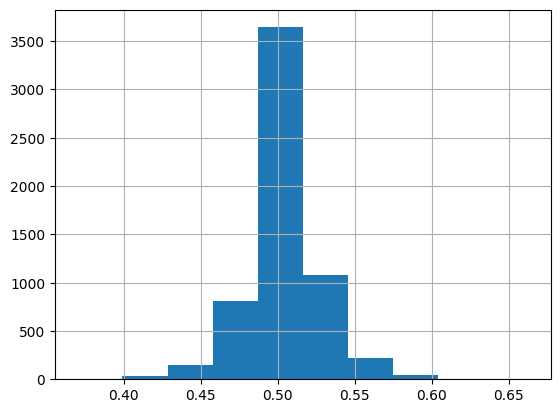

In [28]:
sample_submission['is_laugh'].hist()
sample_submission['is_laugh'].describe()

In [29]:
sample_submission.to_csv(os.path.join(OUTPUT_DIR, f'submission_{os.path.split(OUTPUT_DIR)[-1]}.csv'), index=False)